## Computer Vision

# PART A - 20 Marks

- **DOMAIN:**  Entertainment <br/><br/>
- **CONTEXT:**  Company  X  owns  a  movie  application  and  repository  which  caters  movie  streaming  to  millions  of  users  who  on  subscription  basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and  clicks  on  cast  information  button,  the  app  will  show  details  of  the  actor  in  the  scene.  Company  has  an  in-house  computer  vision  and
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. <br/><br/>
- **DATA DESCRIPTION:** The dataset comprises of images and its mask for corresponding human face.<br/><br/>
- **PROJECT  OBJECTIVE:**  To build a face detection system.  

## Steps and tasks: [ Total Score: 20 Marks]

### 1. Import and Understand the data [7 Marks]
<ol style="list-style-type: upper-alpha;">
    <li> Import and read ‘images.npy’. [1 Marks] </li>
    <li> Split the data into Features(X) & labels(Y). Unify shape of all the images. [3 Marks] <br/>
    <em style='font-size:13px'> Imp Note: Replace all the pixels within masked area with 1. <br/>
    Hint: X will comprise of array of image whereas Y will comprise of coordinates of the mask(human face). Observe: data[0], data[0][0], data[0][1]. </em></li>
    <li> Split the data into train and test[400:9]. [1 Marks] </li>
    <li> Select random image from the train data and display original image and masked image. [2 Marks] </li>
</ol>

##### Q. 1.A. Import and read ‘images.npy’.

In [10]:
#Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from IPython.display import clear_output
import zipfile

import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from tqdm import tqdm

import warnings

In [11]:
RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

if RunningInCOLAB:
  #We are running this on Google Colab
  from google.colab import drive
  drive.mount('/content/drive')
  project_dir='/content/drive/MyDrive/Tuhin/AI-ML Course - UT Austin/Projects/8-Computer Vision' #Our project directory is mounted here
else:
  #We are running in local machine
  project_dir='.' #Our project directory is local directory

In [3]:
# Load images and labels from the .npy file

file_path = f'{project_dir}/images.npy'
data = np.load(file_path, allow_pickle=True)
data.shape

(409, 2)

##### Q. 1.B. Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [4]:
#First standardize the image shape

#We use MobileNetV2 for transfer learning. This model expects the input image to be of shape (224,224,3)
image_height = 224
image_width  = 224
channels     = 3

#Create X and Y sets
X = np.zeros((int(data.shape[0]),image_height, image_width, 3)) #Contains the original image (reshaped)
Y = np.zeros((int(data.shape[0]), image_height, image_width)) #Contains masks corresponding to the face co-ordinates

#Now populate the X and Y sets
no_of_images = len(data)
#Loop through the data to extract the face region and replace the pixel values with 1
errors = []
pbar=tqdm(range(no_of_images), ascii=True)
for i in pbar:
    img = data[i][0]  #Load original image array
    img = cv2.resize(img, dsize=(image_height, image_width), interpolation=cv2.INTER_CUBIC) #Resize the image to 224x224

    #If any image has only 1 channel (grayscale), then we will convert it to 3 channels (color)
    #Also, we will use 3 channels only, so let's try to discard the alpha channel if it exists
    try:
      if len(img.shape) == 2: #Image is 2D array
        errors.append(f"Found image {i} as Grayscale image, changed it 3 channel color image.\n")
        # convert the grayscale image to color so that the number of channels are standardized to 3
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

      if img.shape[2] > 3: #Image has more than 3 channels, most likely alpha channel present
        #Discard extra channels
        img = img[:,:,:3]

    except Exception as e:
      #We discard images with are unusual shape
      errors.append(f"Exception received: {e}. Discarded image {i}.\n")
      continue
    #Now populate the X and Y sets
    X[i] = np.array(img, dtype=np.float32)
    for mask in data[i][1]:
        if 'Face' in mask['label']:
            x1=int(mask['points'][0]['x'] * image_width)
            y1=int(mask['points'][0]['y'] * image_height)
            x2=int(mask['points'][1]['x'] * image_width)
            y2=int(mask['points'][1]['y'] * image_height)
            Y[i][y1:y2, x1:x2] = 1 # set all pixels within the mask co-ordinates to 1.
print()
print()
for error in errors:
  print(error)
print(f"X and Y populated, shape of X is '{X.shape}' and the shape of Y is '{Y.shape}' ")

100%|##########| 409/409 [00:00<00:00, 882.33it/s]



Found image 272 as Grayscale image, changed it 3 channel color image.

X and Y populated, shape of X is '(409, 224, 224, 3)' and the shape of Y is '(409, 224, 224)' 


##### Q. 1.C. Split the data into train and test[400:9].

In [5]:
#Split X and Y in train in test sets with 400:9 ratio
X_train = X[:400]
Y_train = Y[:400]
X_test = X[400:]
Y_test = Y[400:]

print(X_train.shape)
print(X_test.shape)

(400, 224, 224, 3)
(9, 224, 224, 3)


##### Q. 1.D. Select random image from the train data and display original image and masked image.

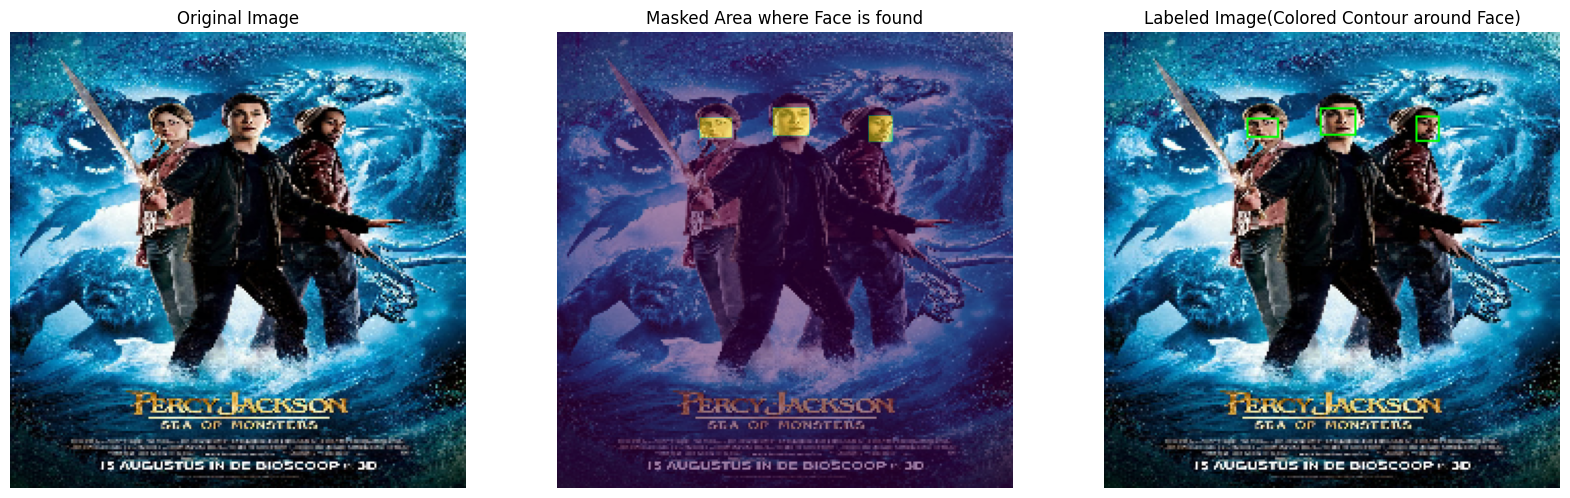

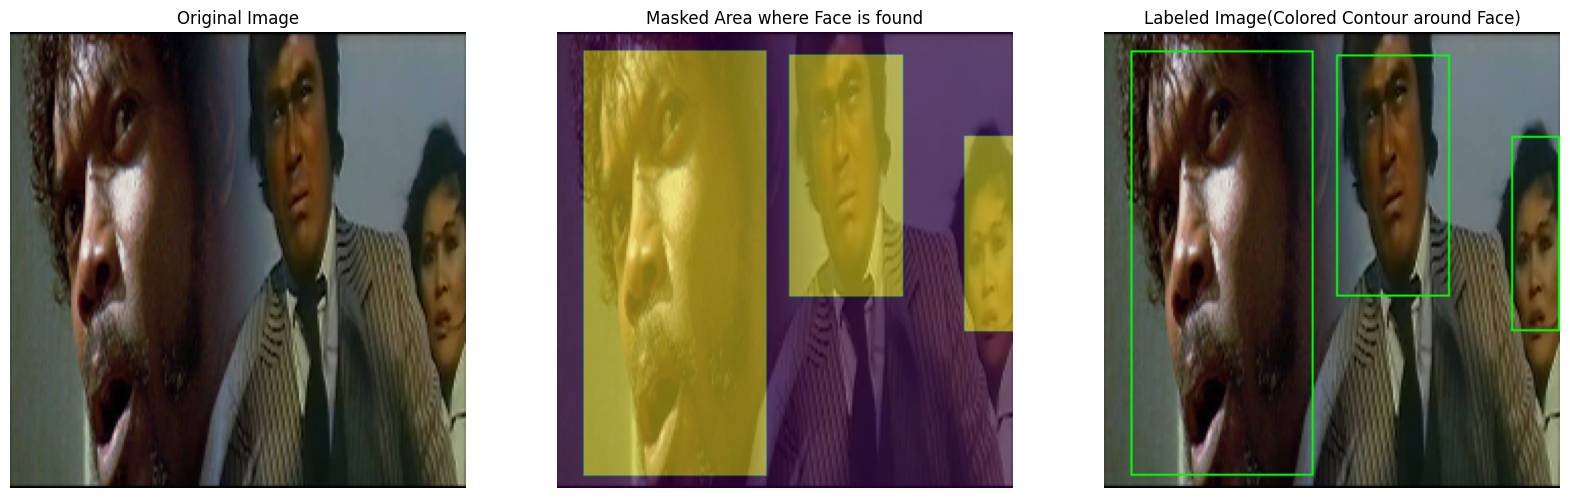

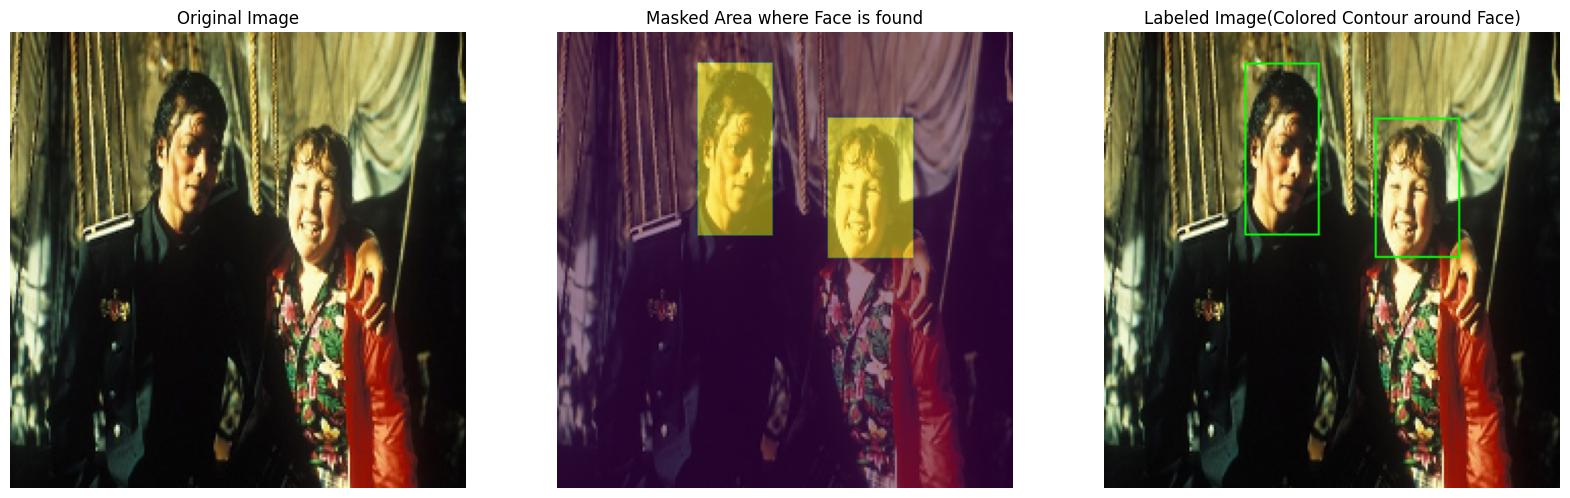

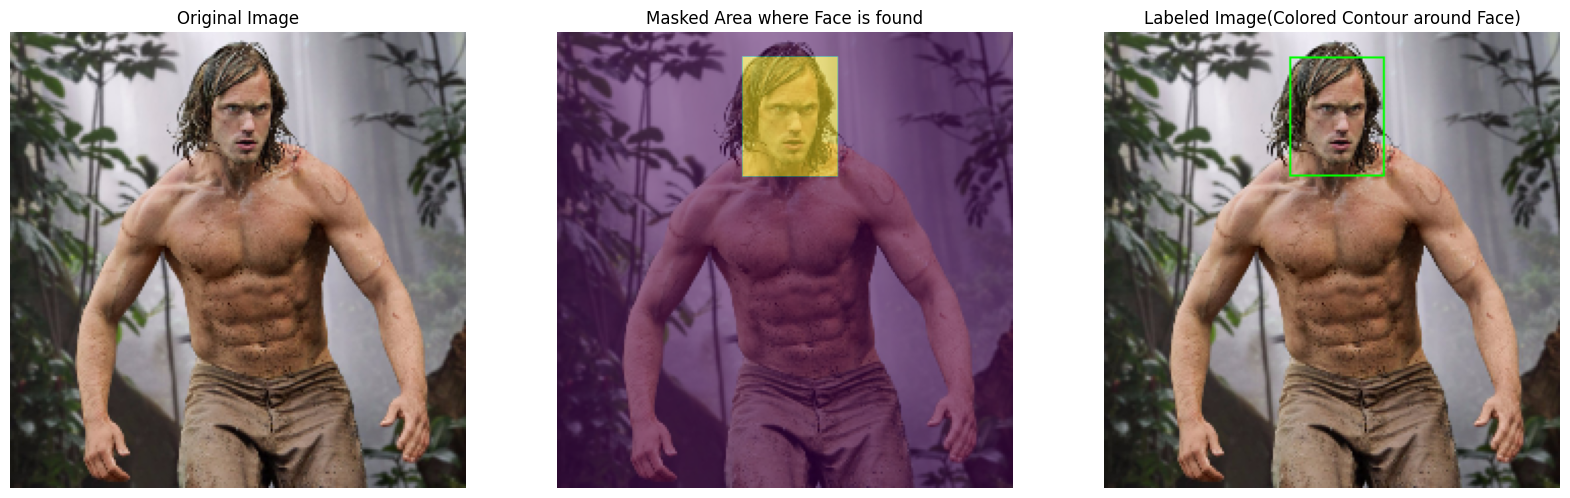

In [6]:
def show_image(index):
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    axs[0].imshow((X_train[index]/255).astype(np.float32))
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    axs[1].imshow((X_train[index]/255).astype(np.float32))
    axs[1].imshow(Y_train[index], alpha=0.5)
    axs[1].set_title("Masked Area where Face is found")
    axs[1].axis('off')
    #Draw a countour around detected face in test_image from the predicted masked area
    contours, _ = cv2.findContours(Y_train[index].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contoured_image = np.copy(X_train[index])
    cv2.drawContours(contoured_image, contours, -1, (0, 255, 0), 1)
    axs[2].imshow((contoured_image/255).astype(np.float32))
    axs[2].set_title("Labeled Image(Colored Contour around Face)")
    axs[2].axis('off')
    plt.show()

#Select 4 random images from train data and display original image and masked image
indexes = np.random.randint(0, X_train.shape[0], size=4)
for index in indexes:
    show_image(index)

### 2. Model building [11 Marks]
<ol style="list-style-type: upper-alpha;">
    <li> Design a face mask detection model. [4 Marks] <br/>
    <em style='font-size:13px'> Hint: 1. Use MobileNet architecture for initial pre-trained non-trainable layers. <br/>
    Hint: 2. Add appropriate Upsampling layers to imitate U-net architecture. </em></li>
    </li>
    <li> Design your own Dice Coefficient and Loss function. [2 Marks] <br/>
    </li>
    <li> Train and tune the model as required. [3 Marks]  </li>
    <li> Evaluate and share insights on performance of the model. [2 Marks] </li>
</ol>

##### Q. 2.A. Design a face mask detection model

In [7]:
# Define the model
def model():

    #Define the model

    #We will use MobileNetV2 for transfer learning. This model expects the input image to be of shape (224,224,3)
    #Input Image Layer
    input = tf.keras.layers.Input([image_height, image_width, 3], dtype = tf.uint8, name="original_input_image")

    #Preprocess the input image
    x = tf.cast(input, tf.float32)

    input_image_name = x.name.split('/')[0]

    x = tf.keras.applications.mobilenet.preprocess_input(x)

    #Load the MobileNetV2 model with the preprocessed input images
    encoder = tf.keras.applications.MobileNetV2(input_tensor=x, input_shape=(image_height,image_width, 3), weights="imagenet", include_top=False, alpha=0.35)

    #make encoder layer (including all sub-layers in it) non-trainable
    encoder.trainable = False

    encoder_output = encoder.get_layer("block_13_expand_relu").output

    skip_connection_names = [input_image_name, "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]

    #Decoder

    #Convolution filters for decoder: last layer will have 16 filters, previous layers will have 32, 48 and 64 filters
    f = [16, 32, 48, 64]

    #The bwlow 'x' will be the input to out decoder
    x = encoder_output

    # There are four repeatative layers corresponding to the skip connections:
    ### each layer will have 3 following sub-layers:
    #### 1. One upsampling (doubleing the dimention) and concat it with out of corresponding encoder layer (in the order: 'input image', 'block 1 relu', 'block 3 relu' and 'block 6 relu' )
    #### 2. And two sets of Convulution with 3x3 kernel , batch normalization with relu activation (no of filters will be decreasing in each layer in this order: 64, 48, 32, 16)
    for i in range(1, len(skip_connection_names)+1, 1):

        #Sub-layer 1
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
        x = tf.keras.layers.Concatenate()([x, x_skip])

        #Sub-layer 2
        x = tf.keras.layers.Conv2D(f[-i], (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)

        #Sub-layer 3
        x = tf.keras.layers.Conv2D(f[-i], (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)

    #Output with sigmoid activation - 0 or 1 output
    x = tf.keras.layers.Conv2D(1, (1, 1), padding="same")(x)
    output = tf.keras.layers.Activation("sigmoid")(x)


    model = tf.keras.models.Model(inputs=[input], outputs=[output])
    return model


In [8]:
#Create the model
model = model()
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 original_input_image (Inpu  [(None, 224, 224, 3)]        0         []                            
 tLayer)                                                                                          
                                                                                                  
 tf.cast (TFOpLambda)        (None, 224, 224, 3)          0         ['original_input_image[0][0]']
                                                                                                  
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)          0         ['tf.cast[0][0]']             
 a)                                                                                               
                                                                                            

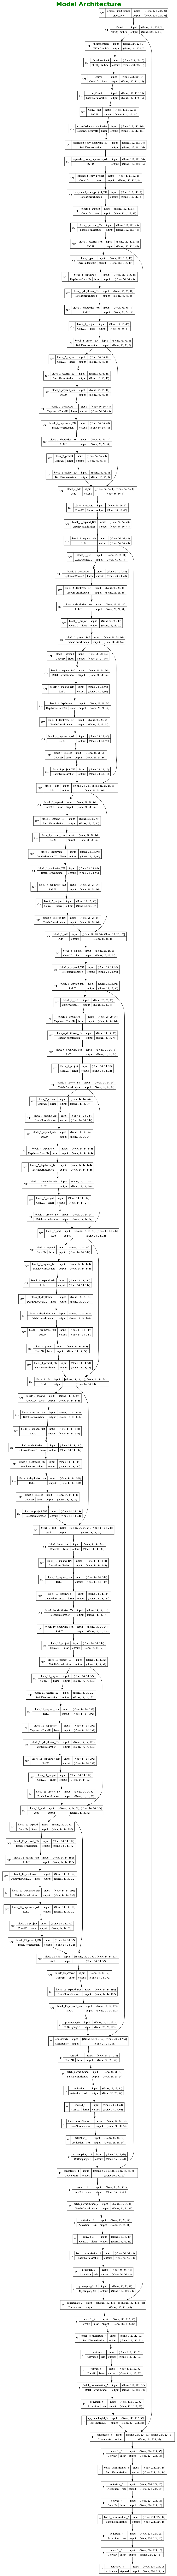

In [9]:
#Show the model architecture
dot_img_file = f'{project_dir}/model.png' # model image file

tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, show_layer_activations=True, show_trainable=True)

fig, axs = plt.subplots(1, 1, figsize=(400, 200))
axs.imshow(plt.imread(dot_img_file))
axs.set_title('Model Architecture', fontsize=26, fontweight='bold', color='Green')
axs.axis('off')
plt.show()



##### Q. 2.B. Design your own Dice Coefficient and Loss function.

In [10]:
smooth = tf.keras.backend.epsilon()
def dice_coef(y_true, y_pred):
  y_true_flatten = tf.keras.backend.flatten(y_true)
  y_pred_flatten = tf.keras.backend.flatten(y_pred)
  intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
  union        = tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten)
  return (2 * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
  return 1.0 - dice_coef(y_true, y_pred)

##### Q. 2.C. Train and tune the model as required.

In [11]:
# Set some hyper parameters
epochs = 500 #@param {type:"integer"}
batch_size = 8 #@param {type:"integer"}
learning_rate = 1e-4 #@param {type:"number"}


In [12]:
#Compile the model with optimizer and metrics
opt = tf.keras.optimizers.Nadam(learning_rate)
metrics = [dice_coef, tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.Precision(name='precision')]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [13]:
#Callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [14]:
#Fit the model
train_steps = len(X_train)//batch_size
test_steps = len(X_test)//batch_size

if len(X_train) % batch_size != 0:
    train_steps += 1
if len(X_test) % batch_size != 0:
    test_steps += 1

model_run=model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    callbacks=callbacks
)

Epoch 1/500
50/50 [==============================] - 19s 57ms/step - loss: 0.7820 - dice_coef: 0.2180 - recall: 0.8853 - precision: 0.1276 - val_loss: 0.7699 - val_dice_coef: 0.2264 - val_recall: 0.9951 - val_precision: 0.1089 - lr: 1.0000e-04
Epoch 2/500
50/50 [==============================] - 1s 20ms/step - loss: 0.7325 - dice_coef: 0.2675 - recall: 0.9441 - precision: 0.1580 - val_loss: 0.7408 - val_dice_coef: 0.2550 - val_recall: 0.9923 - val_precision: 0.1541 - lr: 1.0000e-04
Epoch 3/500
50/50 [==============================] - 1s 20ms/step - loss: 0.6888 - dice_coef: 0.3112 - recall: 0.9137 - precision: 0.2413 - val_loss: 0.6853 - val_dice_coef: 0.3109 - val_recall: 0.9268 - val_precision: 0.3043 - lr: 1.0000e-04
Epoch 4/500
50/50 [==============================] - 1s 21ms/step - loss: 0.6504 - dice_coef: 0.3496 - recall: 0.9112 - precision: 0.3056 - val_loss: 0.6665 - val_dice_coef: 0.3302 - val_recall: 0.9649 - val_precision: 0.3186 - lr: 1.0000e-04
Epoch 5/500
50/50 [========

##### Q. 2.D. Evaluate and share insights on performance of the model.

In [15]:
metrics=model.evaluate(X_test, Y_test, steps = test_steps)
print("Model Performance Metrics:")
print(f" Dice Loss        = {metrics[0]}")
print(f" Dice Coefficient = {metrics[1]}")
print(f" Recall           = {metrics[2]}")
print(f" Precision        = {metrics[3]}")

2/2 [==============================] - 0s 13ms/step - loss: 0.3909 - dice_coef: 0.6087 - recall: 0.6927 - precision: 0.6776
Model Performance Metrics:
 Dice Loss        = 0.3909347653388977
 Dice Coefficient = 0.6086981296539307
 Recall           = 0.6926884651184082
 Precision        = 0.677649736404419


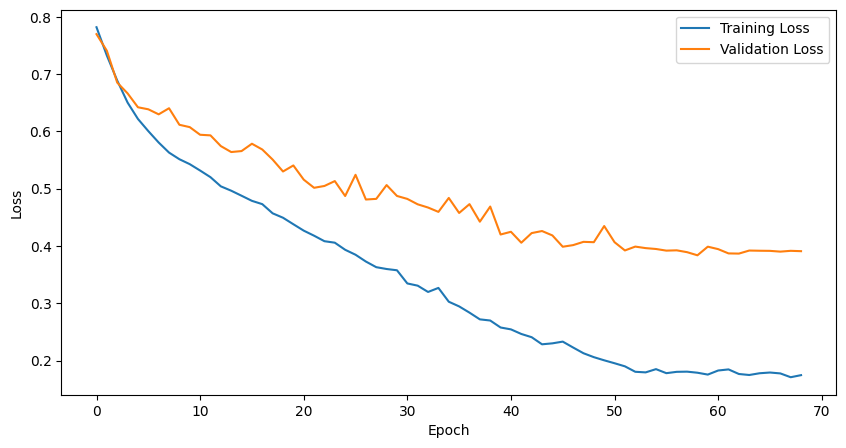

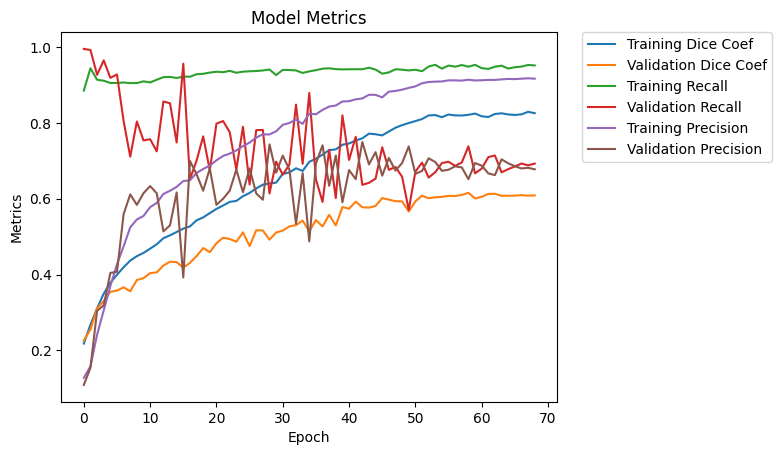

In [16]:
#Show the training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(model_run.history['loss'], label='Training Loss')
plt.plot(model_run.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#Show the training vs validation dice coef over the epochs
plt.plot(model_run.history['dice_coef'], label='Training Dice Coef')
plt.plot(model_run.history['val_dice_coef'], label='Validation Dice Coef')
plt.plot(model_run.history['recall'], label='Training Recall')
plt.plot(model_run.history['val_recall'], label='Validation Recall')
plt.plot(model_run.history['precision'], label='Training Precision')
plt.plot(model_run.history['val_precision'], label='Validation Precision')
plt.title('Model Metrics')
plt.ylabel('Metrics')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

##### Insight of the performance of the model
- The model has been trained on 400 images and tested on 9 images.
- The model has been trained on 500 epochs with batch size of 8, but training ran finished early, as loss is getting flattened out.
- During the run, training loss declined steadily, but validation loss also declined before it stabilized and flattened out.
- Training recall reached a steady value quickly, but validation recall declined over period.
- But precision of training and validation improved over the epochs, however validation precision had lot of ups and down at end.
- Dice coeefficient for both training and testing imporved together and then flattened out.
- Validation metrics have some more up and down, and stabilizes further from corresonding training metrics, this means there is some amount of overfitting, most likely due to imbalanced dataset. 





### 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.[2 Marks]

1/1 [==============================] - 1s 1s/step


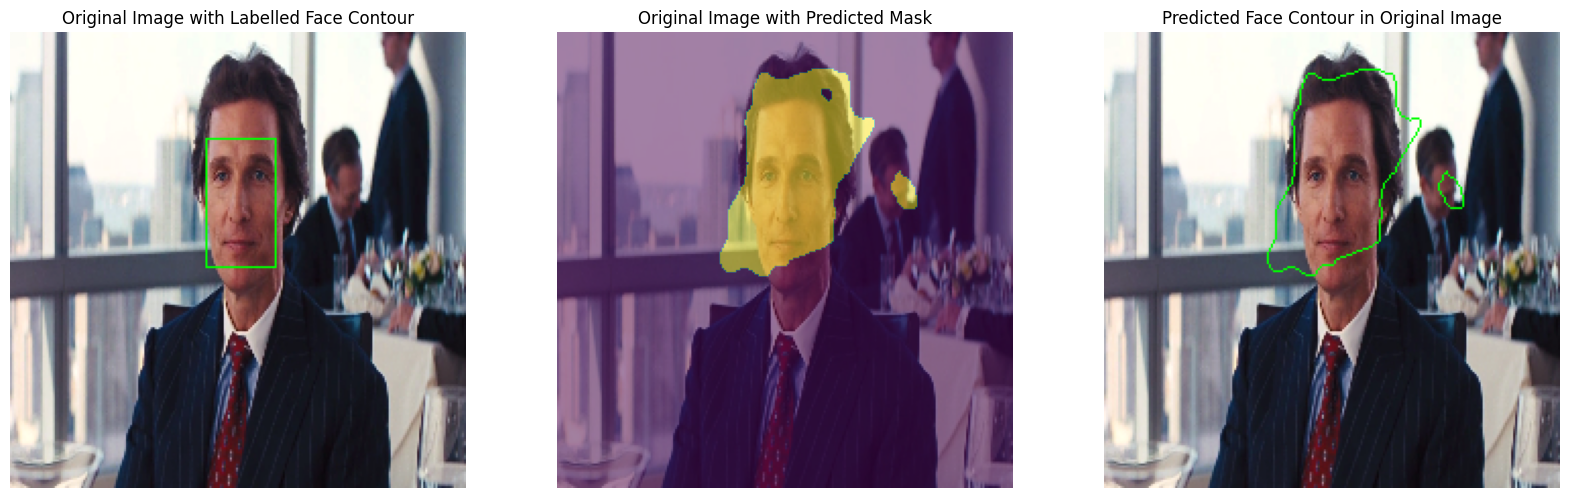

In [17]:
def show_original_vs_predicted_face_area(i):
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))

    test_image = np.copy(X_test[i])
    #Draw a countour around detected face in test_image from the predicted masked area
    contours, _ = cv2.findContours(Y_test[i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(test_image, contours, -1, (0, 255, 0), 1)

    axs[0].imshow((test_image/255).astype(np.float32))
    axs[0].set_title("Original Image with Labelled Face Contour")
    axs[0].axis('off')

    test_image = np.copy(X_test[i])

    Y_pred = model.predict(np.array([test_image]))
    pred_mask = cv2.resize((1.0*(Y_pred[0] > 0.5)), (image_width,image_height))

    axs[1].imshow((test_image/255).astype(np.float32))
    axs[1].imshow(pred_mask, alpha=0.5)
    axs[1].set_title("Original Image with Predicted Mask")
    axs[1].axis('off')

    #Draw a countour around detected face in test_image from the predicted masked area
    contours, _ = cv2.findContours(pred_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(test_image, contours, -1, (0, 255, 0), 1)

    axs[2].imshow((test_image/255).astype(np.float32))
    axs[2].set_title("Predicted Face Contour in Original Image")
    axs[2].axis('off')

    plt.show()


#Show third image
show_original_vs_predicted_face_area(3)


In [18]:
del data
del X
del Y
del model

# PART B - 10 Marks

- **DOMAIN:**  Entertainment <br/><br/>
- **CONTEXT:**  Company  X  owns  a  movie  application  and  repository  which  caters  movie  streaming  to  millions  of  users  who  on  subscription  basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and  clicks  on  cast  information  button,  the  app  will  show  details  of  the  actor  in  the  scene.  Company  has  an  in-house  computer  vision  and
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. <br/><br/>
- **DATA DESCRIPTION:** The dataset comprises of images and its mask for corresponding human face.<br/><br/>
- **PROJECT  OBJECTIVE:**  To create an image dataset to be used by AI team build an image classi fier data. Profile images of people are given.

## Steps and tasks: [ Total Score: 10 Marks]

### 1. Read/import images from folder ‘training_images’. [2 Marks]

In [19]:
#Import images from folder 'training_images'

#Unzip the file training_images.zip into session
training_images_zip = f'{project_dir}/training_images.zip' 

#We will extract to local folder, loading image from google drive is time consuming
training_images_extract_folder = 'training_images'

with zipfile.ZipFile(training_images_zip, 'r') as zip_ref:
    zip_ref.extractall(training_images_extract_folder)

training_images  = os.listdir(training_images_extract_folder+'/training_images')
print(training_images)


['real_00909.jpg', 'real_00902.jpg', 'real_00554.jpg', 'real_00791.jpg', 'real_00331.jpg', 'real_00231.jpg', 'real_00799.jpg', 'real_00939.jpg', 'real_00704.jpg', 'real_00738.jpg', 'real_00917.jpg', 'real_00545.jpg', 'real_00329.jpg', 'real_00427.jpg', 'real_00782.jpg', 'real_00698.jpg', 'real_01024.jpg', 'real_00881.jpg', 'real_01048.jpg', 'real_00425.jpg', 'real_00658.jpg', 'real_00074.jpg', 'real_00729.jpg', 'real_00736.jpg', 'real_00751.jpg', 'real_00235.jpg', 'real_00775.jpg', 'real_00896.jpg', 'real_00821.jpg', 'real_00945.jpg', 'real_00092.jpg', 'real_01056.jpg', 'real_00864.jpg', 'real_00402.jpg', 'real_00461.jpg', 'real_00793.jpg', 'real_00348.jpg', 'real_00994.jpg', 'real_00410.jpg', 'real_00889.jpg', 'real_00954.jpg', 'real_00028.jpg', 'real_00670.jpg', 'real_01036.jpg', 'real_00723.jpg', 'real_00257.jpg', 'real_00464.jpg', 'real_00959.jpg', 'real_00505.jpg', 'real_00383.jpg', 'real_00166.jpg', 'real_00955.jpg', 'real_00002.jpg', 'real_00039.jpg', 'real_00256.jpg', 'real_001

### 2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images. [3 Marks ]
<em style='font-size:15px'>Hint: You can use ’haarcascade_frontalface_default.xml’ from internet to detect faces which is available open source. </em>

In [20]:
#Iterate through all images in the folder and predict the face area
#use  'haarcascade_frontalface_default.xml' from internet to detect faces which is available open source.
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

pbar=tqdm(training_images, ascii=True)
for img in pbar:
    pbar.set_description(img)
    original_image = cv2.imread(f'{training_images_extract_folder}/training_images/{img}')

    #use face_cascade to detect face area

    #Covert to grayscale and equalize the histogram of the grayscale image.
    gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)

    faces = face_cascade.detectMultiScale(gray)
    pbar.set_postfix({'num_faces': len(faces)})


real_00952.jpg: 100%|##########| 1091/1091 [01:08<00:00, 15.89it/s, num_faces=1]


### 3. From the same loop above, extract metadata of the faces and write into a DataFrame. [3 Marks]
Sample output: <br/>
<table style="border:1px solid black;margin-left:auto;margin-right:auto;">
    <tr>
        <th></th>
        <th>x</th>
        <th>y</th>
        <th>w</th>
        <th>h</th>
        <th>Total_Faces</th>
        <th>Image_Name</th>
    </tr>
    <tr>
        <td>0</td>
        <td>94</td>
        <td>144</td>
        <td>390</td>
        <td>390</td>
        <td>1</td>
        <td>real_00251.jpg</td>
    </tr>
    <tr>
        <td>1</td>
        <td>65</td>
        <td>87</td>
        <td>459</td>
        <td>459</td>
        <td>1</td>
        <td>real_00537.jpg</td>
    </tr>

</table>

In [21]:
#Extract the face area from the original image as above and save it in a Dataframe with columns 'x', 'y', 'w', 'h', 'Total_Faces' and 'Image_Name'
face_data = []
for img in tqdm(training_images, ascii=True):
    original_image = cv2.imread(f'{training_images_extract_folder}/training_images/{img}')
    gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    faces = face_cascade.detectMultiScale(gray)
    total_faces = len(faces)
    if(total_faces==0):
        face_data.append([0,0,0,0,0, img]) #No faces found
    for (x, y, w, h) in faces:
        face_data.append([x,y,w,h,total_faces, img])
face_data = pd.DataFrame(face_data, columns=['x','y','w','h','Total_Faces', 'Image_Name'])
print()
print(face_data)

100%|##########| 1091/1091 [01:06<00:00, 16.50it/s]


        x    y    w    h  Total_Faces      Image_Name
0      73  120  427  427            1  real_00909.jpg
1      62   79  462  462            1  real_00902.jpg
2      96  156  405  405            1  real_00554.jpg
3      90   76  413  413            1  real_00791.jpg
4     122  130  425  425            1  real_00331.jpg
...   ...  ...  ...  ...          ...             ...
1228   30    9  512  512            1  real_00924.jpg
1229   68   53  456  456            1  real_00400.jpg
1230    2   52   56   56            2  real_01073.jpg
1231   86  139  408  408            2  real_01073.jpg
1232   58   14  486  486            1  real_00952.jpg

[1233 rows x 6 columns]


### 4. Save the output Dataframe in .csv format. [2 Marks]

In [22]:
#Save the dataframe to a csv file
face_data_csv = f'{project_dir}//face_data.csv' 

face_data.to_csv(face_data_csv, index=False)

del face_data

# PART C - 30 Marks

- **DOMAIN:**  Face Recognition <br/><br/>
- **CONTEXT:**  Company X intends to build a face identification model to recognise human faces. <br/><br/>
- **DATA DESCRIPTION:** The dataset comprises of images and its mask where there is a human face.<br/><br/>
- **PROJECT  OBJECTIVE:**  Face  Aligned  Face  Dataset  from  Pinterest.  This  dataset  contains  10,770  images  for  100  people.  All  images  are  taken
from 'Pinterest' and aligned using dlib library. Some data samples:

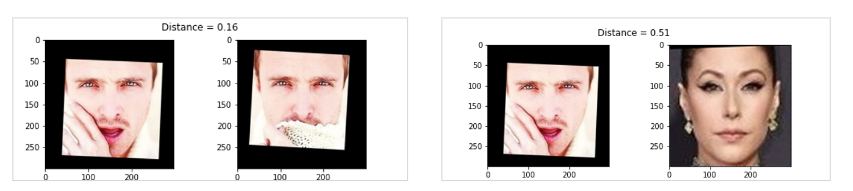

## Steps and tasks: [ Total Score: 30 Marks]

### 1. Unzip, read and Load data(‘PINS.zip’) into session. [2 Marks]

In [13]:
#Unzip the file PINS.zip into session
pins_zip = f'{project_dir}/PINS.zip' 

#We will extract to local folder, loading image from google drive is time consuming
pins_extract_folder = 'PINS'

with zipfile.ZipFile(pins_zip, 'r') as zip_ref:
    zip_ref.extractall(pins_extract_folder)

### 2. Write function to create metadata of the image. [4 Marks]
<em style='font-size:15px'>Hint: Metadata means derived information from the available data which can be useful for particular problem statement. </em>


In [14]:
#Write function to create metatdata for the images
#[This is copied from the Hint notebook shared - 'Hint - CV - 2_Part 2_.ipynb']

#Class to create metadata for the image file
# base - base directory of the dataset
# name - identity name
# file - image file name
# person_name : name of the person, after pins_ in the folder name
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file
        #Person name : this is done by removing prefix pins_ from the file name
        self.person_name = name.split('_')[1]

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)


### 3. Write a loop to iterate through each and every image and create metadata for all the images. [4 Marks]


In [15]:
#Function to load metadata
#This loops through the dataset and creates metadata for each image
#path - path of the dataset
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

#Now load the metadata for the images from 'PINS/PINS' folder (the PINS.zip folder unzipped into 'PINS' folder, which contents another PINS folder with images)
pins_folder = f'{pins_extract_folder}/PINS'

metadata = load_metadata(pins_folder)

#This function reads the image data from the given image path
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]



[[[67 56 50]
  [62 51 45]
  [56 45 39]
  ...
  [22 19 12]
  [22 19 12]
  [23 18 12]]

 [[65 54 48]
  [64 53 47]
  [56 45 39]
  ...
  [22 19 12]
  [22 19 12]
  [23 18 12]]

 [[61 50 46]
  [59 48 44]
  [47 36 30]
  ...
  [23 18 12]
  [23 18 12]
  [23 18 12]]

 ...

 [[60 40 41]
  [60 40 41]
  [56 36 37]
  ...
  [30 21 16]
  [31 22 17]
  [31 22 17]]

 [[60 40 41]
  [60 40 41]
  [57 37 38]
  ...
  [30 21 16]
  [31 22 17]
  [31 22 17]]

 [[61 41 42]
  [60 40 41]
  [57 37 38]
  ...
  [30 21 16]
  [31 22 17]
  [31 22 17]]]


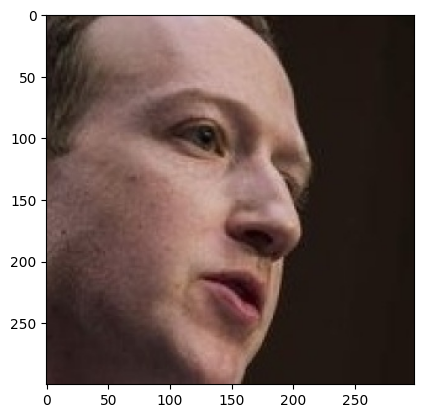

In [16]:
# Print and display the first image to check
img=load_image(metadata[0].image_path())
print(img)
plt.imshow(img)
plt.show()

### 4. Generate Embeddings vectors on the each face in the dataset. [4 Marks]
Hint: Use ‘vgg_face_weights.h5’


In [27]:
#Define the VGG model
def vgg_face():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.Convolution2D(4096, (7, 7), activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Convolution2D(4096, (1, 1), activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Convolution2D(2622, (1, 1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Activation('softmax'))
    return model



In [28]:
#Now create the VGG model and load the weights
weight_file = f'{project_dir}/vgg_face_weights.h5' 

model = vgg_face()
model.load_weights(weight_file)

In [29]:
#Create the VGG Face Descriptor model - this model will be used to extract the features from the images (embeddings)
#Therfore we will remove the last layer from the VGG model and use the output of the second last layer as the output of the new model
vgg_face_descriptor = tf.keras.models.Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [30]:
# Getting embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtaining embedding vector for an image
# Getting the embedding vector for the above image using vgg_face_descriptor model and printing the shape

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 1s 740ms/step
(2622,)


In [31]:
#Get the embedding vectors for all the images in the metadata

#initialize the embeddings : embeding size per image will be 2622 (as seen from the output above)
embeddings = np.zeros((metadata.shape[0], 2622))

#We will generate embeddings using batch of images
batch_size=1000 #@param {type:"integer"}

total_batches=len(embeddings)//batch_size + (1 if (len(embeddings)%batch_size > 0) else 0)
for idx in range(0, len(embeddings), batch_size):

  #Batch image indexe - start and end values
  start = idx
  end   = idx+batch_size if idx+batch_size < len(embeddings) else len(embeddings)

  #create the input array of batch size - each input tensor of size [224,224,3]
  inputs = np.zeros([end-start,224,224,3])

  #get the metadata at for the batch 'start' to 'end'
  #and populate the input vector array
  pbar=tqdm(metadata[start:end], ascii=True)
  pbar.set_description(f'Batch {idx//batch_size+1} of {total_batches}')

  for i,m in enumerate(pbar):
    img = load_image(m.image_path())
    try:
        img = load_image(m.image_path())
        # scale RGB values to interval [0,1]
        img = cv2.resize(img, dsize = (224,224))
        img = (img / 255.).astype(np.float32)
        #Set the input tensor for the image
        inputs[i] = np.expand_dims(img, axis=0)[0]
    except Exception as e:
        print(str(e))
        print(i,m)

  #Now set the embeddings for the batch
  embeddings[start:end] = vgg_face_descriptor.predict(inputs)

  del inputs #delete to release memory

  print() #print a newline for the pbar


Batch 1 of 11: 100%|##########| 1000/1000 [00:04<00:00, 230.98it/s]


32/32 [==============================] - 3s 48ms/step



Batch 2 of 11: 100%|##########| 1000/1000 [00:04<00:00, 226.78it/s]


32/32 [==============================] - 1s 29ms/step



Batch 3 of 11: 100%|##########| 1000/1000 [00:04<00:00, 223.87it/s]


32/32 [==============================] - 1s 29ms/step



Batch 4 of 11: 100%|##########| 1000/1000 [00:04<00:00, 226.67it/s]


32/32 [==============================] - 1s 29ms/step



Batch 5 of 11: 100%|##########| 1000/1000 [00:04<00:00, 227.17it/s]


32/32 [==============================] - 1s 29ms/step



Batch 6 of 11: 100%|##########| 1000/1000 [00:04<00:00, 226.87it/s]


32/32 [==============================] - 1s 29ms/step



Batch 7 of 11: 100%|##########| 1000/1000 [00:04<00:00, 227.22it/s]


32/32 [==============================] - 1s 30ms/step



Batch 8 of 11: 100%|##########| 1000/1000 [00:04<00:00, 225.56it/s]


32/32 [==============================] - 1s 29ms/step



Batch 9 of 11: 100%|##########| 1000/1000 [00:04<00:00, 226.01it/s]


32/32 [==============================] - 1s 30ms/step



Batch 10 of 11: 100%|##########| 1000/1000 [00:04<00:00, 225.00it/s]


32/32 [==============================] - 1s 29ms/step



Batch 11 of 11: 100%|##########| 770/770 [00:03<00:00, 225.48it/s]


25/25 [==============================] - 1s 47ms/step



### 5. Build distance metrics for identifying the distance between two similar and dissimilar images. [4 Marks]


In [32]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

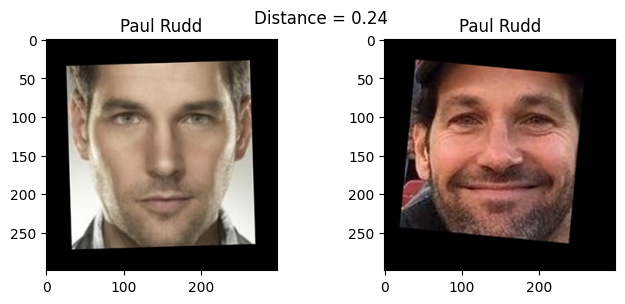

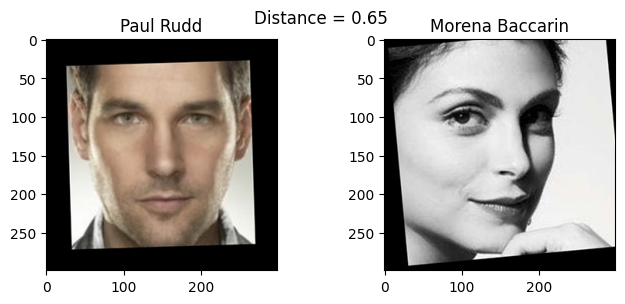

In [33]:

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.title(metadata[idx1].person_name)
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));
    plt.title(metadata[idx2].person_name)
show_pair(102, 103)
show_pair(102, 480)

### 6. Use PCA for dimensionality reduction. [2 Marks]


In [34]:
#Create train and test data

#All indexes which is divisible by 9 will be test images, rest are train images. So, 90% images are for training, 10% is for testing
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Create X_train and X_test using the above indices
X_train = embeddings[train_idx]
X_test = embeddings[test_idx]

#For each image 'person_name' from the metadata is the target label
targets = np.array([m.person_name for m in metadata])

#Again store the y_train and y_test as per the same indices as above
y_train = targets[train_idx]
y_test = targets[test_idx]


In [35]:
# Encode the target identities
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)


In [36]:
#Scale the features using StandardScaler

# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [37]:
# Reduce feature dimensions using Principal Component Analysis

# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.55366322  18.95781462  22.92683789 ...  99.99999983  99.99999999
 100.        ]


In [38]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 346


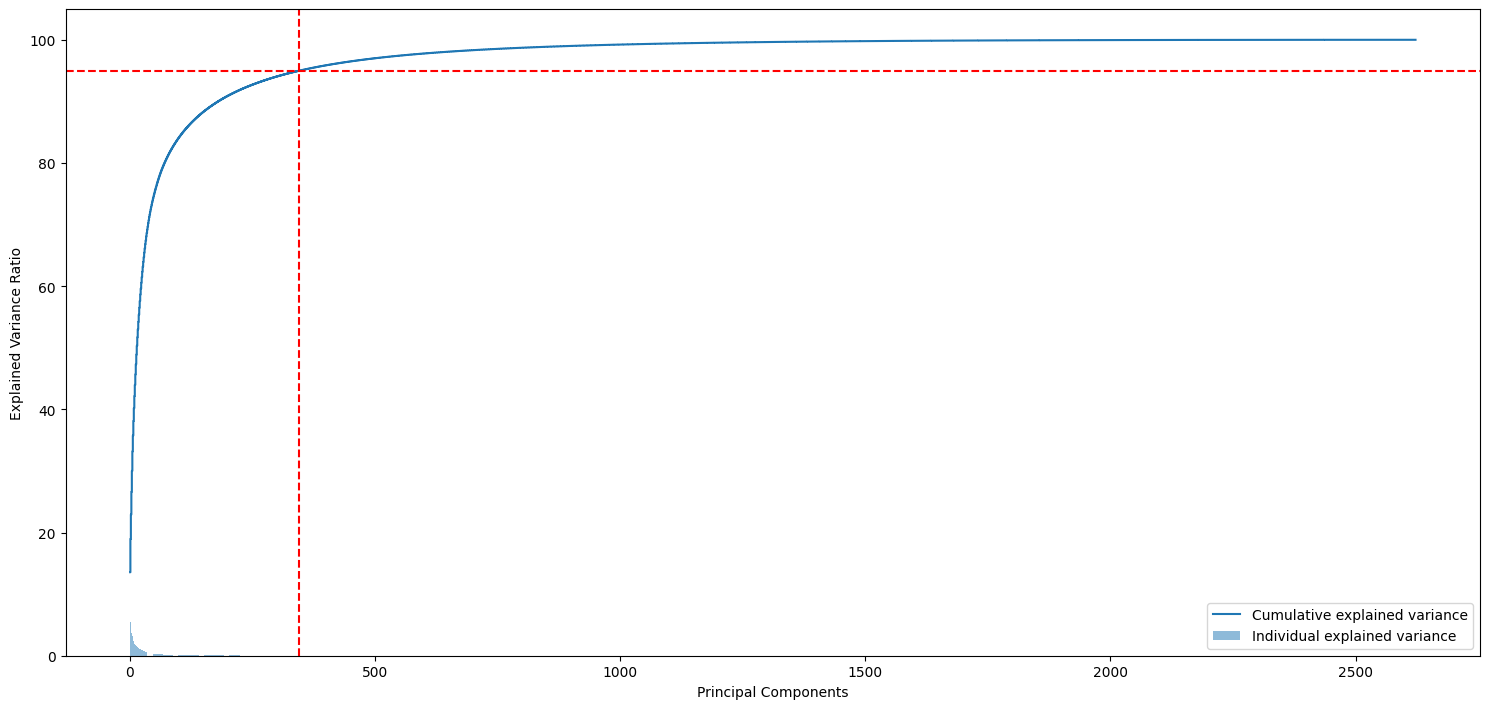

In [39]:
# Ploting
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [40]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = 20, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 346)

(1197, 346)

### 7. Build an SVM classifier in order to map each image to its right person. [4 Marks]


In [41]:
#Try to get the best parameters for SVC using grid search

params_grid = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'class_weight': ['balanced', None]}]

svc_search = GridSearchCV(SVC(random_state = 20, verbose=True), params_grid, cv = 3, scoring = 'f1_macro', verbose=4)
svc_search.fit(X_train_pca, y_train)

print()
print('Best estimator found by grid search:')
print(svc_search.best_estimator_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LibSVM][CV 1/3] END C=1, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.667 total time=  22.3s
[LibSVM][CV 2/3] END C=1, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.678 total time=  21.7s
[LibSVM][CV 3/3] END C=1, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.683 total time=  22.2s
[LibSVM][CV 1/3] END C=1, class_weight=balanced, gamma=0.001, kernel=rbf;, score=0.958 total time=  15.6s
[LibSVM][CV 2/3] END C=1, class_weight=balanced, gamma=0.001, kernel=rbf;, score=0.961 total time=  15.9s
[LibSVM][CV 3/3] END C=1, class_weight=balanced, gamma=0.001, kernel=rbf;, score=0.956 total time=  15.6s
[LibSVM][CV 1/3] END C=1, class_weight=balanced, gamma=0.0001, kernel=rbf;, score=0.939 total time=  21.3s
[LibSVM][CV 2/3] END C=1, class_weight=balanced, gamma=0.0001, kernel=rbf;, score=0.936 total time=  20.7s
[LibSVM][CV 3/3] END C=1, class_weight=balanced, gamma=0.0001, kernel=rbf;, score=0.940 tota

In [42]:
#Use the best estimator as found above
clf = SVC(kernel='rbf', C=svc_search.best_estimator_.C, class_weight=svc_search.best_estimator_.class_weight, gamma=svc_search.best_estimator_.gamma, probability=True, random_state=20)
print(f'Running SVC with the best parameters as found above : {clf}')
clf.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(clf.score(X_train_pca, y_train)))
print('SVC accuracy for test  set: {0:.3f}'.format(clf.score(X_test_pca, y_test)))


Running SVC with the best parameters as found above : SVC(C=1, class_weight='balanced', gamma=0.001, probability=True,
    random_state=20)
SVC accuracy for train set: 0.994
SVC accuracy for test  set: 0.967


### 8.  Import and display the the test images. [2 Marks]
Hint: ‘Benedict Cumberbatch9.jpg’ and ‘Dwayne Johnson4.jpg’ are the test images.


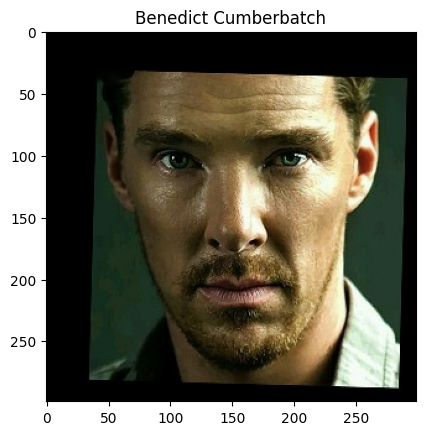

In [43]:

# Suppressing LabelEncoder warning
warnings.filterwarnings('ignore')

#Create a function to display an image
def display_image(image_path, title):
  example_image = load_image(image_path)
  plt.imshow(example_image)
  plt.title(title)

Benedict_Cumberbatch9 = f'{project_dir}/Benedict Cumberbatch9.jpg'
Dwayne_Johnson4       = f'{project_dir}/Dwayne Johnson4.jpg' 

display_image(Benedict_Cumberbatch9, "Benedict Cumberbatch")


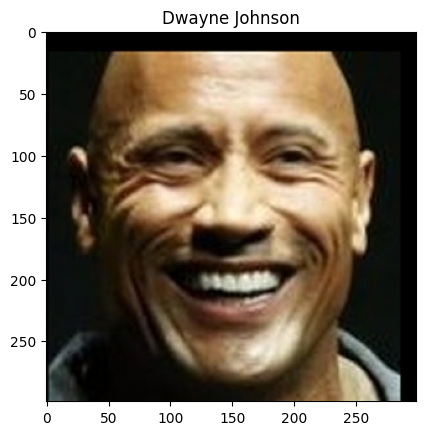

In [44]:
display_image(Dwayne_Johnson4, "Dwayne Johnson")

### 9. Use the trained SVM model to predict the face on both test images. [4 Marks]

1/1 [==============================] - 0s 24ms/step


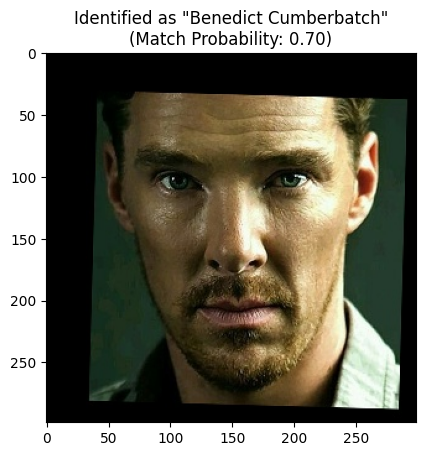

In [45]:
def identify(image_path):
  test_image = load_image(image_path)
  # scale RGB values to interval [0,1]
  img = cv2.resize(test_image, dsize = (224,224))
  img = (img / 255.).astype(np.float32)
  #Set the input tensor for the image
  input = np.expand_dims(img, axis=0)
  test_image_embeddings = vgg_face_descriptor.predict(input)[0]

  #Scale the features using our standard scaler defined earlier
  X_test_new_sc = sc.transform([test_image_embeddings])
  #Reduce feature dimensions using Principal Component Analysis defined earlier
  X_test_new_pca = pca.transform(X_test_new_sc)

  #Predict the identity using the SVC model
  prediction = clf.predict(X_test_new_pca)
  prediction_probability = clf.predict_proba(X_test_new_pca)
  #Get the identity name from the encoder (reverse transform)
  identity = encoder.inverse_transform(prediction)[0]

  #Display the image with the identified name
  plt.imshow(test_image)
  plt.title(f'Identified as "{identity}"\n(Match Probability: {prediction_probability[0][prediction][0]:.2f})')

identify(Benedict_Cumberbatch9)

1/1 [==============================] - 0s 22ms/step


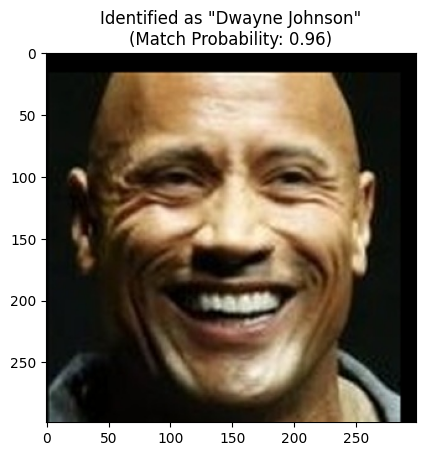

In [46]:
identify(Dwayne_Johnson4)